In [25]:
import os, glob, re, numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_ndim

In [26]:
DIR_A = "data/pose12/labels/val/15"  #  (เช่น คนเดียวกัน ชุดที่ 18)
DIR_B = "data/pose12/labels/test/20"  #  (เช่น คนเดียวกัน ชุดที่ 20)

In [27]:
NUM_KPTS = 12
KEYPOINT_NAMES = [
    'R_Shoulder','L_Shoulder','R_Elbow','L_Elbow',
    'R_Wrist','L_Wrist','R_Hip','L_Hip',
    'R_Knee','L_Knee','R_Ankle','L_Ankle'
]  # ถ้า order ในไฟล์ต่างจากนี้ แค่ถือว่าชื่อคือ index 0..11 ตามลำดับในไฟล์


In [28]:
# scoring sensitivity (ยิ่งมากยิ่งเข้มงวด)
ALPHA = 3.0


In [29]:
# Utilities
# --------------------------
def natural_key(s):
    # natural sort key: frame_000012.txt -> 12
    return [int(t) if t.isdigit() else t for t in re.split(r'(\d+)', s)]

def list_frame_txts(folder):
    files = sorted(glob.glob(os.path.join(folder, "*.txt")), key=natural_key)
    return files

def parse_yolo_kpts_line(line, num_kpts=12):
    """
    Parse single-line YOLO keypoints:
      class cx cy w h  x1 y1 v1  x2 y2 v2 ... xK yK vK
    Returns:
      kpts_xy: (K,2) in [0,1]
      vis:     (K,) visibility values (float)
    """
    vals = [float(x) for x in line.strip().split()]
    if len(vals) < 5 + 3*num_kpts:
        raise ValueError(f"Line has too few values: got {len(vals)} numbers.")
    # skip class, bbox
    kpt_vals = vals[5:5+3*num_kpts]
    kpts_xy = np.array(kpt_vals, dtype=float).reshape(num_kpts, 3)[:, :2]
    vis     = np.array(kpt_vals, dtype=float).reshape(num_kpts, 3)[:, 2]
    return kpts_xy, vis

def load_sequence(folder, num_kpts=12):
    """
    Load all *.txt frames in a folder to arrays:
      seq_xy: (T, K, 2) in [0,1]
      seq_vis:(T, K)     visibility (0/1/2)
      frame_files: list of paths (sorted)
    Assumes one line per file (single person).
    """
    files = list_frame_txts(folder)
    seq_xy, seq_vis = [], []
    for fp in files:
        with open(fp, "r") as f:
            line = f.readline()
        if not line:
            # empty; push NaNs
            seq_xy.append(np.full((num_kpts,2), np.nan))
            seq_vis.append(np.zeros((num_kpts,)))
            continue
        try:
            xy, vis = parse_yolo_kpts_line(line, num_kpts)
        except Exception as e:
            print(f"[WARN] parse failed: {fp}: {e}")
            xy = np.full((num_kpts,2), np.nan)
            vis= np.zeros((num_kpts,))
        # if a joint has vis==0, mark as NaN to interpolate later
        xy_masked = xy.copy()
        xy_masked[vis <= 0.0] = np.nan
        seq_xy.append(xy_masked)
        seq_vis.append(vis)
    if not files:
        raise FileNotFoundError(f"No .txt frames found in {folder}")
    return np.array(seq_xy, dtype=float), np.array(seq_vis, dtype=float), files

def interpolate_nans_1d(arr):
    """
    arr: (T,) with NaN; returns interpolated (linear) array.
    """
    x = np.arange(arr.shape[0])
    mask = ~np.isnan(arr)
    if mask.sum() == 0:
        return arr  # all NaN -> keep NaN
    if mask.sum() == 1:
        # only one value -> fill all with that value
        return np.full_like(arr, arr[mask][0])
    return np.interp(x, x[mask], arr[mask])

def interpolate_sequence_nans(seq_xy):
    """
    seq_xy: (T, K, 2) with NaNs -> interpolate over time per joint dim.
    Returns: (T,K,2)
    """
    T, K, D = seq_xy.shape
    out = seq_xy.copy()
    for k in range(K):
        for d in range(D):
            out[:, k, d] = interpolate_nans_1d(out[:, k, d])
    return out

def l2_normalize_per_frame(seq_xy, eps=1e-8):
    """
    seq_xy: (T, K, 2)
    flattens (K*2), L2-normalize per frame, reshape back.
    """
    T, K, D = seq_xy.shape
    flat = seq_xy.reshape(T, K*D)
    norms = np.linalg.norm(flat, axis=1, keepdims=True) + eps
    flat = flat / norms
    return flat.reshape(T, K, D)

def dtw_to_similarity_exp(dist, alpha=3.0):
    return float(100.0 * np.exp(-alpha * dist))  # 0..100

In [30]:
# --------------------------
# Load both sequences
# --------------------------
seqA_xy_raw, seqA_vis, filesA = load_sequence(DIR_A, NUM_KPTS)
seqB_xy_raw, seqB_vis, filesB = load_sequence(DIR_B, NUM_KPTS)

print(f"A: {DIR_A}  frames={len(filesA)}")
print(f"B: {DIR_B}  frames={len(filesB)}")

A: data/pose12/labels/val/15  frames=31
B: data/pose12/labels/test/20  frames=32


In [31]:
# --------------------------
# Interpolate missing joints (v==0 -> NaN -> linear interp)
# --------------------------
seqA_xy = interpolate_sequence_nans(seqA_xy_raw)
seqB_xy = interpolate_sequence_nans(seqB_xy_raw)

In [32]:
# --------------------------
# Frame-level L2 normalization
# --------------------------
seqA_norm = l2_normalize_per_frame(seqA_xy)
seqB_norm = l2_normalize_per_frame(seqB_xy)

In [33]:
# --------------------------
# DTW per joint (2D) + Similarity
# --------------------------
dists = []
sims  = []
for j in range(NUM_KPTS):
    A = seqA_norm[:, j, :]  # (T_A, 2)
    B = seqB_norm[:, j, :]  # (T_B, 2)
    dist = dtw_ndim.distance(A, B)
    sim  = dtw_to_similarity_exp(dist, alpha=ALPHA)
    dists.append(dist); sims.append(sim)

dists = np.array(dists, dtype=float)
sims  = np.array(sims,  dtype=float)

avg_dist = float(np.nanmean(dists))
avg_sim  = float(np.nanmean(sims))

print("\n===== Summary =====")
print(f"Average DTW distance     : {avg_dist:.6f}")
print(f"Average Similarity (exp) : {avg_sim:.2f}%  (alpha={ALPHA})")



===== Summary =====
Average DTW distance     : 0.044438
Average Similarity (exp) : 87.69%  (alpha=3.0)


In [34]:
# --------------------------
# Diagnostics: missing ratio
# --------------------------
missingA = np.isnan(seqA_xy_raw).sum()
missingB = np.isnan(seqB_xy_raw).sum()
totalA   = np.prod(seqA_xy_raw.shape)
totalB   = np.prod(seqB_xy_raw.shape)
print(f"\nMissing (before interp):")
print(f"A: {missingA}/{totalA}  ({100*missingA/totalA:.2f}%)")
print(f"B: {missingB}/{totalB}  ({100*missingB/totalB:.2f}%)")


Missing (before interp):
A: 0/744  (0.00%)
B: 0/768  (0.00%)


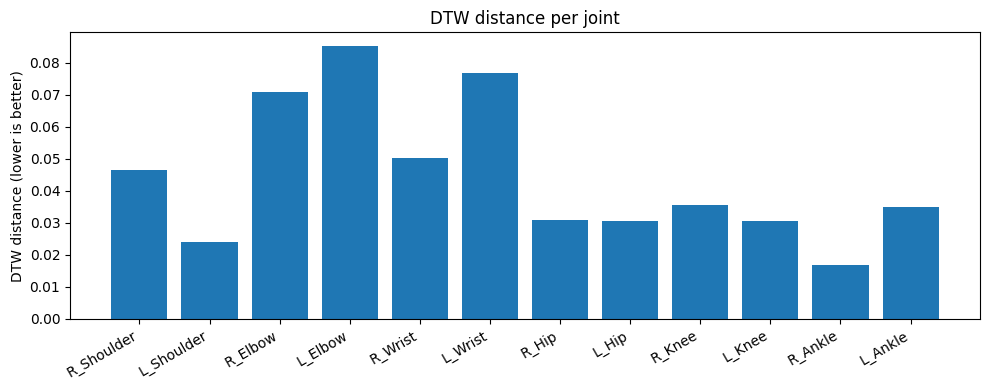

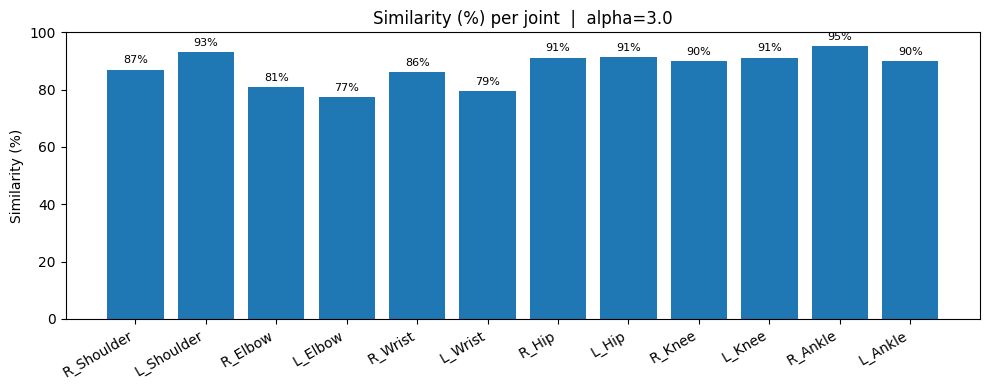

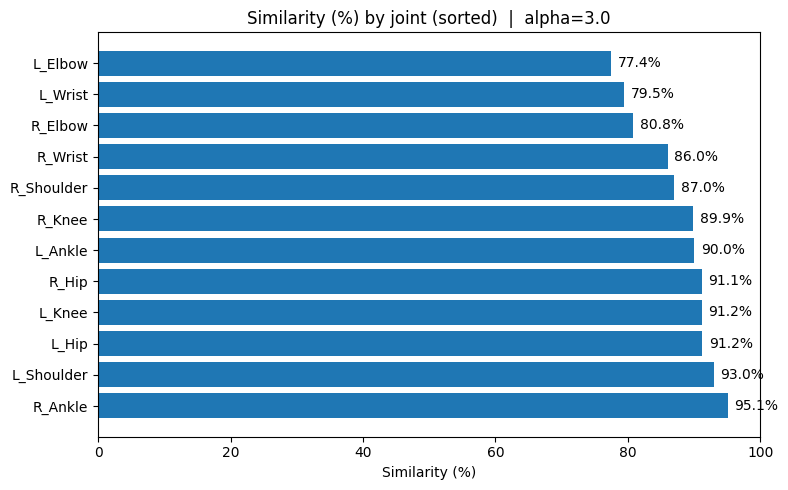

In [35]:
# --------------------------
# Plots
# --------------------------
# (1) DTW distance per joint
plt.figure(figsize=(10,4))
x = np.arange(NUM_KPTS)
plt.bar(x, dists)
plt.xticks(x, KEYPOINT_NAMES, rotation=30, ha='right')
plt.ylabel("DTW distance (lower is better)")
plt.title("DTW distance per joint")
plt.tight_layout()
plt.show()

# (2) Similarity (%) per joint (unsorted + sorted)
plt.figure(figsize=(10,4))
plt.bar(x, sims)
plt.xticks(x, KEYPOINT_NAMES, rotation=30, ha='right')
plt.ylim(0, 100)
plt.ylabel("Similarity (%)")
plt.title(f"Similarity (%) per joint  |  alpha={ALPHA}")
for xi, v in zip(x, sims):
    plt.text(xi, v + 1.5, f"{v:.0f}%", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

order = np.argsort(sims)[::-1]
plt.figure(figsize=(8,5))
plt.barh(np.array(KEYPOINT_NAMES)[order], sims[order])
plt.xlim(0, 100)
plt.xlabel("Similarity (%)")
plt.title(f"Similarity (%) by joint (sorted)  |  alpha={ALPHA}")
for yi, v in enumerate(sims[order]):
    plt.text(v + 1.0, yi, f"{v:.1f}%", va='center')
plt.tight_layout()
plt.show()


Worst joint: L_Elbow  |  DTW=0.0852  |  Sim=77.44%


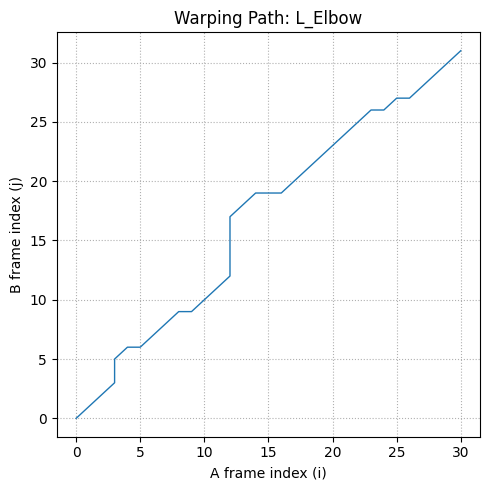

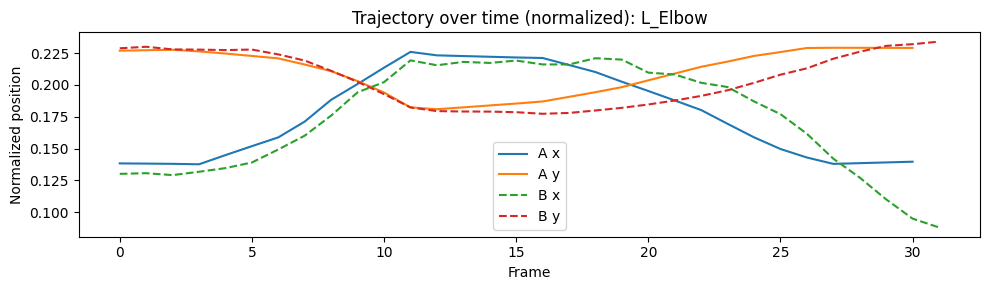

In [36]:
# (3) Warping path + Trajectory for the worst joint (lowest similarity)
worst_idx = int(np.argmin(sims))
sel_name  = KEYPOINT_NAMES[worst_idx]
print(f"\nWorst joint: {sel_name}  |  DTW={dists[worst_idx]:.4f}  |  Sim={sims[worst_idx]:.2f}%")

# Build warping path (try 2D path; fallback to 1D flattened)
A = seqA_norm[:, worst_idx, :]
B = seqB_norm[:, worst_idx, :]
try:
    path = dtw_ndim.warping_path(A, B)
except Exception:
    path = dtw.warping_path(A.reshape(-1), B.reshape(-1))
pij = np.array(path)

plt.figure(figsize=(5,5))
plt.plot(pij[:,0], pij[:,1], linewidth=1)
plt.xlabel("A frame index (i)")
plt.ylabel("B frame index (j)")
plt.title(f"Warping Path: {sel_name}")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(A[:,0], label="A x"); plt.plot(A[:,1], label="A y")
plt.plot(B[:,0], '--', label="B x"); plt.plot(B[:,1], '--', label="B y")
plt.title(f"Trajectory over time (normalized): {sel_name}")
plt.xlabel("Frame"); plt.ylabel("Normalized position")
plt.legend(); plt.tight_layout(); plt.show()

In [38]:
# =========================================================
# ✅ Per-frame similarity/distance using frame-level DTW
#    (แก้ปัญหา index out of bounds)
# =========================================================
import numpy as np

def dtw_frames_path(A_flat, B_flat):
    """
    DTW บนแกนเฟรม:
      A_flat: (T1, F), B_flat: (T2, F)
    คืน: path (list of (i,j)), cost matrix D (T1 x T2), local distance C (T1 x T2)
    """
    T1, F = A_flat.shape
    T2 = B_flat.shape[0]
    # local distance matrix: L2 per frame pair
    C = np.linalg.norm(A_flat[:, None, :] - B_flat[None, :, :], axis=2)  # (T1,T2)

    # DP for accumulated cost
    D = np.full((T1+1, T2+1), np.inf, dtype=float)
    D[0, 0] = 0.0
    for i in range(1, T1+1):
        for j in range(1, T2+1):
            D[i, j] = C[i-1, j-1] + min(D[i-1, j], D[i, j-1], D[i-1, j-1])

    # traceback
    i, j = T1, T2
    path = []
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        choices = [D[i-1, j], D[i, j-1], D[i-1, j-1]]
        a = int(np.argmin(choices))
        if a == 0:
            i -= 1
        elif a == 1:
            j -= 1
        else:
            i -= 1; j -= 1
    path.reverse()
    return path, D[1:, 1:], C

def compute_per_frame_similarity_fixed(seqA_norm, seqB_norm, alpha=3.0):
    """
    seqA_norm, seqB_norm: (T, K, 2) ที่ normalize แล้ว
    คืน:
      frames_A: ดัชนีเฟรมฝั่ง A (0..T_A-1)
      per_frame_sim: similarity เฉลี่ยต่อเฟรม A (0..100)
      per_frame_dist: distance เฉลี่ยต่อเฟรม A
      path_ij: warping path ระหว่างเฟรม (i,j)
    """
    T1, K, D = seqA_norm.shape
    T2 = seqB_norm.shape[0]

    # flatten ต่อเฟรม -> ฟีเจอร์ยาว F=K*2 (แต่ยังคง "เฟรม" เป็นหน่วย)
    A_flat = seqA_norm.reshape(T1, K*D)
    B_flat = seqB_norm.reshape(T2, K*D)

    path, Dacc, C = dtw_frames_path(A_flat, B_flat)  # path คือ list ของ (i,j) เฟรม
    path_arr = np.array(path, dtype=int)

    # local distance ตามคู่เฟรมบน path
    step_dists = C[path_arr[:, 0], path_arr[:, 1]]           # (L,)
    step_sims  = 100.0 * np.exp(-alpha * step_dists)         # (L,)

    # เฉลี่ยเป็นคะแนนต่อเฟรมฝั่ง A
    per_frame_sim  = np.full((T1,), np.nan, dtype=float)
    per_frame_dist = np.full((T1,), np.nan, dtype=float)
    sum_sim = np.zeros((T1,), dtype=float)
    sum_dis = np.zeros((T1,), dtype=float)
    cnt     = np.zeros((T1,), dtype=int)

    for (i, j), s, d in zip(path, step_sims, step_dists):
        sum_sim[i] += s
        sum_dis[i] += d
        cnt[i]     += 1

    mask = cnt > 0
    per_frame_sim[mask]  = sum_sim[mask] / cnt[mask]
    per_frame_dist[mask] = sum_dis[mask] / cnt[mask]

    frames_A = np.arange(T1)
    return frames_A, per_frame_sim, per_frame_dist, path_arr


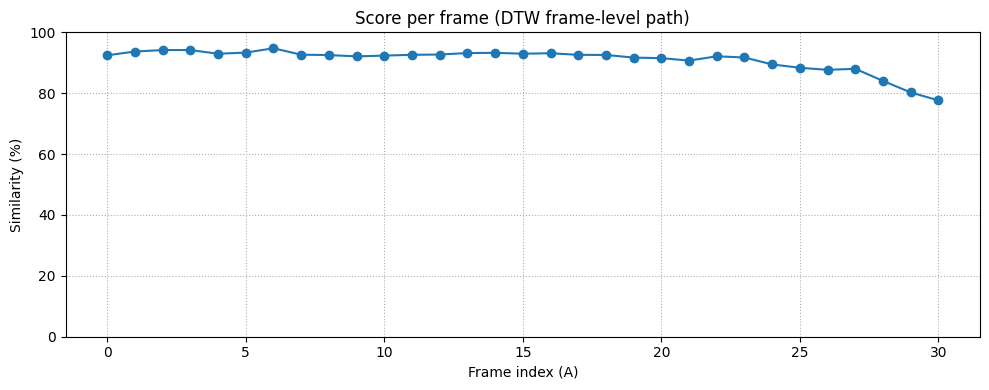

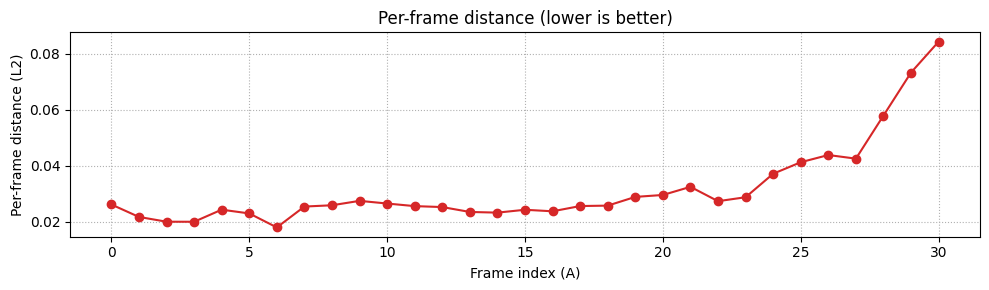

Per-frame similarity: mean=91.02% | min=77.64% | max=94.76%


In [39]:
frames_A, per_sim, per_dist, path_ij = compute_per_frame_similarity_fixed(
    seqA_norm, seqB_norm, alpha=ALPHA
)

# Plot Score per frame
plt.figure(figsize=(10,4))
plt.plot(frames_A, per_sim, '-o')
plt.xlabel("Frame index (A)")
plt.ylabel("Similarity (%)")
plt.ylim(0, 100)
plt.title("Score per frame (DTW frame-level path)")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

# Plot Distance per frame
plt.figure(figsize=(10,3))
plt.plot(frames_A, per_dist, '-o', color='tab:red')
plt.xlabel("Frame index (A)")
plt.ylabel("Per-frame distance (L2)")
plt.title("Per-frame distance (lower is better)")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

print(f"Per-frame similarity: mean={np.nanmean(per_sim):.2f}% | "
      f"min={np.nanmin(per_sim):.2f}% | max={np.nanmax(per_sim):.2f}%")
